In [1]:
!nvidia-smi

Wed Dec 20 19:25:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
pip install rouge

Note: you may need to restart the kernel to use updated packages.


# **IMPORTING THE NECESSARY LIBRARIES**

In [3]:
import os
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import pickle
import tensorflow as tf
from tensorflow import keras
from rouge import Rouge
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU,RepeatVector
from tensorflow.keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **IMPORING THE DATASET**

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/kaggle/input/intern-data"

In [5]:
!kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail

100%|███████████████████████████████████████▊| 501M/503M [00:04<00:00, 93.5MB/s]
100%|█████████████████████████████████████████| 503M/503M [00:04<00:00, 109MB/s]


In [6]:
!unzip \*.zip && rm *.zip

Archive:  newspaper-text-summarization-cnn-dailymail.zip
  inflating: cnn_dailymail/test.csv  
  inflating: cnn_dailymail/train.csv  
  inflating: cnn_dailymail/validation.csv  


In [11]:
train_data = pd.read_csv('/kaggle/working/cnn_dailymail/train.csv')
train_data = train_data.drop(['id'], axis = 1)
train_data

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...
287108,By . James Rush . Former first daughter Chelse...,Chelsea Clinton said question of running for o...
287109,An apologetic Vanilla Ice has given his first ...,"Vanilla Ice, 47 - real name Robert Van Winkle ..."
287110,America's most lethal sniper claimed he wished...,America's most lethal sniper made comment in i...
287111,"By . Sara Malm . PUBLISHED: . 12:19 EST, 8 Mar...",A swarm of more than one million has crossed b...


In [12]:
print("the shape of the train data is",train_data.shape)

the shape of the train data is (287113, 2)


In [13]:
test_data = pd.read_csv('/kaggle/working/cnn_dailymail/test.csv')
test_data = test_data.drop(['id'], axis = 1)
test_data

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."
...,...,...
11485,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...
11486,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...
11487,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...
11488,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...


In [14]:
print("the shape of the test data is ", test_data.shape)

the shape of the test data is  (11490, 2)


In [15]:
valid_data = pd.read_csv('/kaggle/working/cnn_dailymail/validation.csv')
valid_data = valid_data.drop(['id'], axis = 1)
valid_data

,article,highlights
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...
...,...,...
13363,All shops will be allowed to offer ‘click and ...,Shops won't have to apply for planning permiss...
13364,Mo Farah has had his nationality called into q...,Mo Farah broke the European half-marathon reco...
13365,Wolves kept their promotion hopes alive with a...,Wolves are three points off the play-off place...
13366,A Brown University graduate student has died ...,"Hyoun Ju Sohn, a 25-year-old doctoral student,..."


In [16]:
print("the shape of the valid data is ", valid_data.shape)

the shape of the valid data is  (13368, 2)


The train data is comparatively very high wrt to test and valid data. so lets us scale down the train data and use it and use only the test data from the dataset and split the train data to train data and valid data

In [17]:
del valid_data

new_train_data = train_data[:110000]
new_train_data.shape

(110000, 2)

# **PREPROCESSING**

In [18]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [19]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

In [20]:
clean_train_summaries = []
for summary in new_train_data['highlights']:
  clean_train_summaries.append(clean_text(summary, remove_stopwords=False))
print("Train data summaries are cleamed")

clean_train_text = []
for text in new_train_data['article']:
  clean_train_text.append(clean_text(text))
print("Train data texts are cleaned")

Train data summaries are cleamed
Train data texts are cleaned


In [21]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_train_text[:110000]
clean_df['summary'] = clean_train_summaries[:110000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_train_text
del clean_train_summaries

In [22]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [23]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [24]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  60.00719413677853
Total Coverage of rare words:  0.7458147584629847
Text Vocab:  133418


In [25]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [26]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  70.11489659306625
Total Coverage of rare words:  2.4837378859339996
Summary Vocab:  29912


In [27]:
maxlen_text = 800
maxlen_summ = 150

In [28]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [29]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

# **PRETRAINED EMBEDDING**

In [30]:
os.environ['KAGGLE_CONFIG_DIR'] = "/kaggle/input/intern-data"

In [31]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

 96%|███████████████████████████████████████▍ | 441M/458M [00:05<00:00, 128MB/s]
100%|████████████████████████████████████████| 458M/458M [00:05<00:00, 87.6MB/s]


In [32]:
!unzip \*.zip && rm *.zip

Archive:  glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [33]:
embeding_index = {}
embed_dim = 100
with open('/kaggle/working/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [34]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [35]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [36]:
del embeding_index

# **MODEL ARCHITECTURE**

In [37]:
latent_dim = 128

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 800)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 800, 100)             1334180   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 256),                234496    ['embedding[0][0]']       

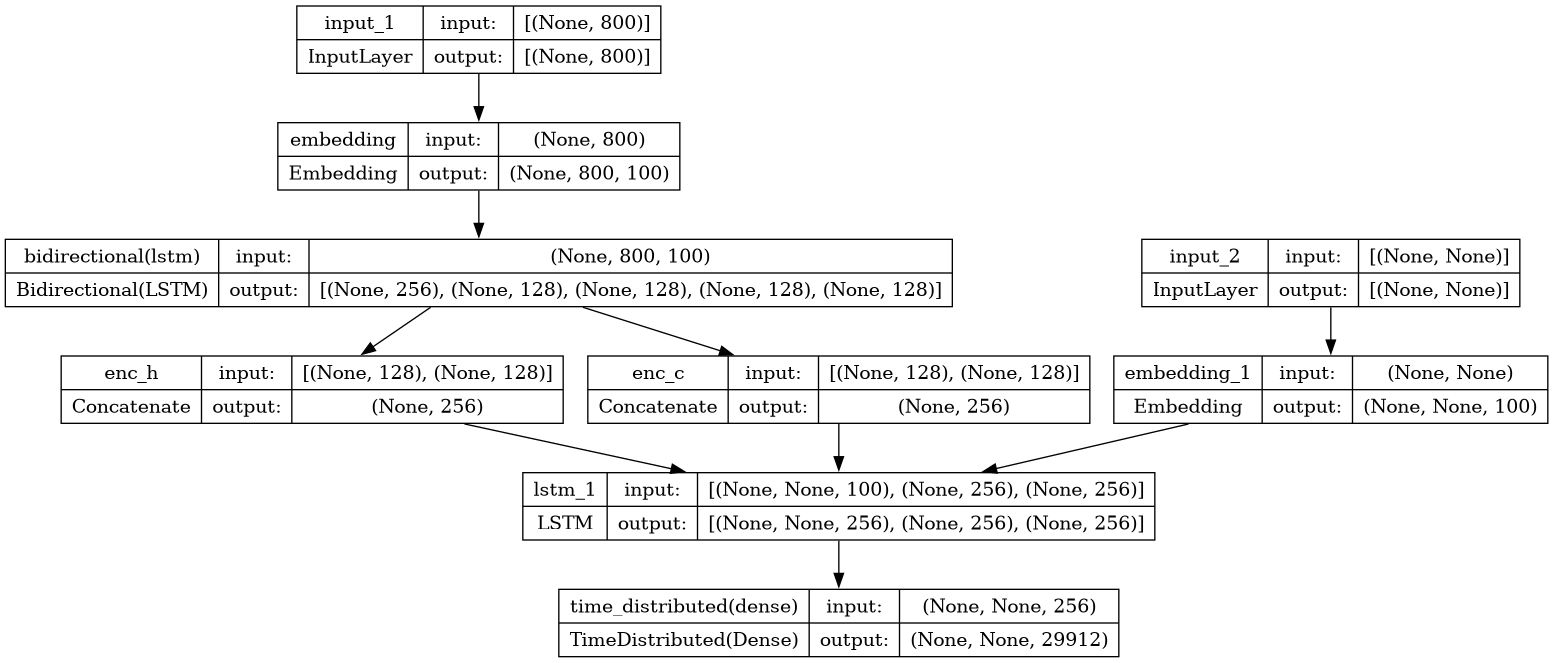

In [38]:
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])

dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit(
    [train_x, train_y[:, :-1]],
    train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:],
    epochs=20,
    callbacks=[early_stop],
    batch_size=128,
    verbose=1,
    validation_data=(
        [val_x, val_y[:, :-1]],
        val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20
774/774 [==============================] - 944s 1s/step - loss: 2.6212 - val_loss: 2.3987
Epoch 2/20
774/774 [==============================] - 952s 1s/step - loss: 2.3692 - val_loss: 2.3201
Epoch 3/20
774/774 [==============================] - 938s 1s/step - loss: 2.3090 - val_loss: 2.2671
Epoch 4/20
774/774 [==============================] - 938s 1s/step - loss: 2.2680 - val_loss: 2.2314
Epoch 5/20
774/774 [==============================] - 940s 1s/step - loss: 2.2360 - val_loss: 2.2039
Epoch 6/20
774/774 [==============================] - 937s 1s/step - loss: 2.2095 - val_loss: 2.1729
Epoch 7/20
774/774 [==============================] - 932s 1s/step - loss: 2.1863 - val_loss: 2.1542
Epoch 8/20
774/774 [==============================] - 925s 1s/step - loss: 2.1655 - val_loss: 2.1337
Epoch 9/20
774/774 [==============================] - 924s 1s/step - loss: 2.1469 - val_loss: 2.1166
Epoch 10/20
774/774 [==============================] - 925s 1s/step - loss: 2.1301 - val_lo

In [40]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [41]:
enc_model.save('./encoder_model.h5')

dec_model.save('./decoder_model.h5')

with open('./s_tokenizer.pkl', 'wb') as f:
    pickle.dump(s_tokenizer, f)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
def generate_summary(input_text):
    with open('./s_tokenizer.pkl', 'rb') as f:
        s_tokenizer = pickle.load(f)

    enc_model = tf.keras.models.load_model('./encoder_model.h5')
    dec_model = tf.keras.models.load_model('./decoder_model.h5')

    input_seq = s_tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=800, padding='post')

    h, c = enc_model.predict(input_seq)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq.strip()

In [68]:
text = "After the success of the three previous editions, the much-anticipated Fourth Nagaland Film Festival will be held on December 7 and 8, 2023 at RCEMPA, Jotsoma in Kohima under the theme Frames of Harmony which is being organised by the Department of Information & Public Relations as part of the ongoing Hornbill Festival 2023, in collaboration with the Film Association of Nagaland (FAN) and Ministry of Information & Broadcasting, Government of India, an official statement said.The Film Festival will host actors, filmmakers from various parts of the country and senior officials from the Central Ministry. The results of the Short Film Competition, organised by the Department of Information & Public Relations, will also be declared during the inaugural event. The Nagaland Film Festival will commence with the inaugural programme at 10 am at RCMEPA, Jotsoma on  December 7. One can attend the Festival free of cost and no fees will be charged for the masterclass and workshops."
get_sum_for_text = generate_summary(text)
print(get_sum_for_text)

1/1 [==============================] - 0s 21ms/step
the family s family is a new york for the new york says he is not to be a new deal to the family s family says he is not not be a new deal to be a new deal


In [48]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [52]:
test_inputs[0].shape

(800,)

In [58]:
predictions = []
for i in range(10):
    our_summ = generate_summary(str(test_inputs[i].reshape(1, maxlen_text)))
    predictions.append(our_summ)

1/1 [==============================] - 0s 22ms/step


# **EVALUATION BY ROGUE SCORE**

In [70]:
rouge = Rouge()
scores = rouge.get_scores(predictions, test_data["highlights"][:10].tolist(), avg=True)

print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")

ROUGE-1: 0.1318
ROUGE-2: 0.0188
ROUGE-L: 0.1318
